In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

#### Loading the Excel Data

In [2]:
url <- "https://github.com/TheABoss/DSCI-100-2023T2-Project-Group-001/raw/main/data/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
#Define URL object for Excel dataset

temp_xls <- tempfile(fileext = ".xls")
#Prepare temp file

download.file(url, destfile = temp_xls)
#Downloading Excel file

know_train_raw <- read_excel(temp_xls,sheet = 2,range = "A1:F259")
#Downloading Excel sheet as tibble containing training data

know_test_raw <- read_excel(temp_xls,sheet = 3,range = "A1:F146")
#Downloading Excel sheet as tibble containing test data

In [3]:
#converting target class (UNS) to factor  
know_train_raw$UNS <- replace(know_train_raw$UNS, know_train_raw$UNS == "very_low", "Very Low")
# Miss-match bettween the exact string used to signify very low bettween test and training,
# This line standardizes it to be "Very Low" in both

know_train <- know_train_raw |>
                mutate(UNS = factor(UNS, levels = c("Very Low", "Low", "Middle", "High")))

know_test_raw$UNS <- replace(know_test_raw$UNS, know_test_raw$UNS == "very_low", "Very Low")
# Miss-match bettween the exact string used to signify very low bettween test and training,
# This line standardizes it to be "Very Low" in both
know_test <- know_test_raw |>
                mutate(UNS = factor(UNS, levels = c("Very Low", "Low", "Middle", "High")))

know_train
know_test

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


#### Setting Seed

In [4]:
set.seed(100)

#### Creating tune model

In [5]:
recipe <- recipe(UNS ~ PEG + SCG + STG + STR, data = know_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

kspec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")


#### placeholder

In [6]:
vfold <- vfold_cv(know_train, v = 5, strata = UNS)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

k_results <- workflow() |>
         add_recipe(recipe) |>
         add_model(kspec) |>
         tune_grid(resamples = vfold, grid = k_vals)|>
         collect_metrics()
            

#### Best K Graph

[1] 17

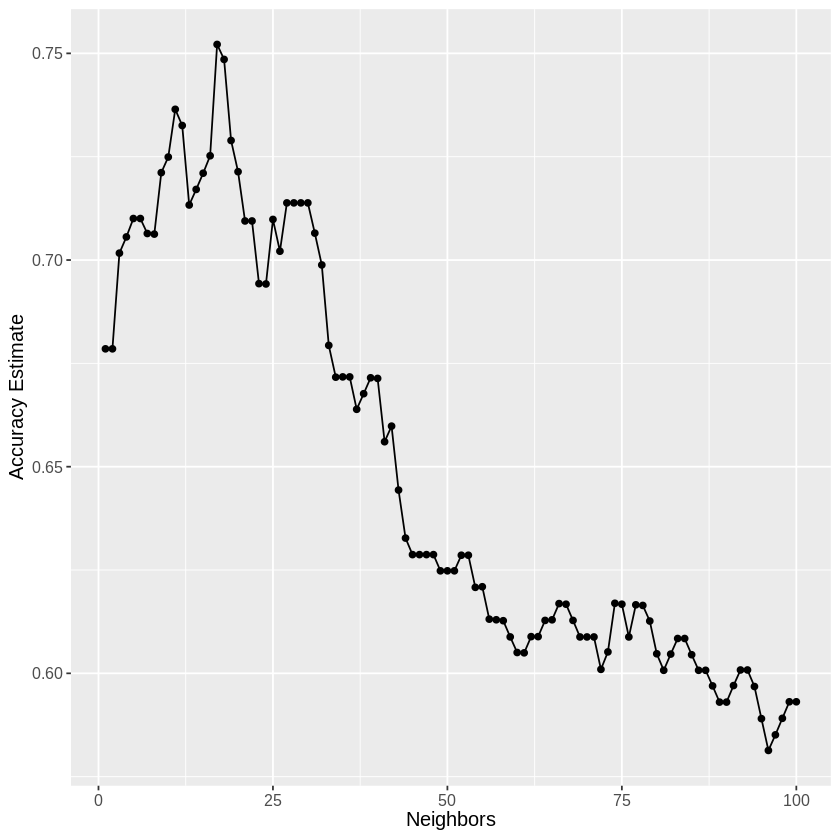

In [7]:
accuracies <- k_results |>
              filter(.metric == "accuracy")

kplot <- ggplot(data = accuracies, aes(x = neighbors,y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors",
                     y = "Accuracy Estimate") +
                theme(text = element_text(size = 12))
# Generating best plot

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
# Printing best K 

best_k
kplot

#### We can see Best k at = 17, as it has the highest accuracy

#### Creating Best model

In [8]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_best_fit <- workflow() |>
                add_recipe(recipe) |>
                add_model(knn_best_spec) |>
                fit(data = know_train)

#### Assessing model accuracy (set up)

In [9]:
knn_predictions <- predict(knn_best_fit, know_test) |>
                    bind_cols(know_test)
knn_predictions

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.10,0.50,0.26,0.05,Very Low
Low,0.05,0.05,0.55,0.60,0.14,Low
High,0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.56,0.60,0.77,0.13,0.32,Low
Middle,0.66,0.68,0.81,0.57,0.57,Middle
Low,0.68,0.64,0.79,0.97,0.24,Middle


In [10]:
knn_predictions |>
                    metrics(truth = UNS, estimate = .pred_class) |>
                    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7034483


#### Confusion matrix

In [12]:
conf <- knn_predictions |>
        conf_mat(truth = UNS, estimate = .pred_class)

conf

          Truth
Prediction Very Low Low Middle High
  Very Low        2   0      0    0
  Low            24  46     10    0
  Middle          0   0     23    8
  High            0   0      1   31